# Project: K-Means Clustering on the Sporulation Dataset

This project involves applying the **K-Means clustering algorithm** to the **sporulation dataset**, which contains gene expression data from yeast during the process of sporulation. The primary objective of this analysis is to explore how well the K-Means algorithm can cluster the genes based on their temporal expression patterns and compare the clustering results with published biological classifications.

## Steps:

- **Preprocessing the data**: This involves cleaning the dataset, converting string values to numerical format, and handling any outliers or irregular data, such as mean and standard deviation rows and normalizing the data.
- **Applying the K-Means algorithm**: The data is clustered into groups using K-Means, where the number of clusters is set to 7 based on biological relevance (following the literature).
- **Visualize the K-Means clusters**: The clusters created by K-Means algorithm are briefly visualized on a 2-dimensional plane.
- **Evaluating clustering performance**: The clustering results are evaluated using the **silhouette index** to assess the quality and coherence of the clusters.
- **Comparison with existing research**: The obtained clusters are compared with the results from the research paper "Comparisons and validation of statistical clustering techniques for microarray gene expression data" by Datta & Datta (2003), which evaluated various clustering techniques on the same dataset. (unfiltered)

### Preprocessing the data  

##### Load the filtered sporulation dataset

In [45]:
import numpy as np
import pandas as pd

# Load the sporulation dataset
df = pd.read_csv('sporulation-filtered.txt', sep='\t')

# Drop the 'Genes' column, as KMeans only works with numerical data
X = df.drop(columns=['Genes'])

# Convert the values from string to float
# Replace ',' with '.' so that the values can be converted to float
X.replace({',': '.'}, regex=True, inplace=True)
X = X.astype(float)
mean = X.iloc[-2, :]
std = X.iloc[-1, :]
X = X.iloc[:-2,:]

# Number of clusters - 7 set because the paper mentions that the number of clusters is 7
clusters = 7
# Number of genes
M = len(X.iloc[:, 0])
# number of Time dimensions
l = len(X.iloc[0, :])

print('Number of genes:', M)
print('Number of time dimensions:', l)


# Normalize the data using the quantile method as it's frequently used in microarray data analysis
# as in the paper it's not mentioned which normalization method is used

# Quantile normalization is frequently used in microarray data analysis
def quantile_normalize(df):
    # Sort each column
    sorted_df = np.sort(df, axis=0)
    
    # Compute the rank means
    rank_means = np.mean(sorted_df, axis=1)
    
    # Replace each value by the corresponding rank mean
    # Get the ranks of the original data
    ranks = np.argsort(np.argsort(df, axis=0), axis=0)
    
    # Create a normalized DataFrame using the rank means
    norm_df = np.zeros(df.shape)
    for i in range(df.shape[1]):  # Iterate over each column
        norm_df[:, i] = rank_means[ranks[:, i]]
    
    return pd.DataFrame(norm_df, columns=df.columns)

X = quantile_normalize(X)
    
X.tail()

Number of genes: 474
Number of time dimensions: 7


,t0,"t0,5",t2,t5,t7,t9,"t11,5"
469,0.568757,-0.399072,0.761932,-0.981090,-1.266280,-0.407033,0.715941
470,0.600150,-0.617564,-0.001640,-0.986150,-0.604192,-0.220052,0.766354
471,0.912232,0.445928,0.362816,-1.230235,-0.686758,-0.542334,0.068079
472,0.820508,0.517894,-0.823741,-0.785677,-0.823741,-0.517034,0.505396
473,0.604755,0.732262,-0.049824,-1.458405,-0.993510,-0.604192,0.772927


##### Prepare datasets without one of the timesteps

In [46]:
# Create a list of gene data without one of the time steps
# t0 t0,5 t2 t5 t7 t9 t11,5
X_without_time_step = [X.drop(columns=['t0']), 
                       X.drop(columns=['t0,5']), 
                       X.drop(columns=['t2']), 
                       X.drop(columns=['t5']), 
                       X.drop(columns=['t7']), 
                       X.drop(columns=['t9']), 
                       X.drop(columns=['t11,5'])]

##### Use the K-means algorithm on the filtered dataset

In [47]:
from sklearn.cluster import KMeans

# Use the KMeans algorithm to cluster the data
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X)
X_clustered = kmeans.predict(X)

X_clustered_without_time_step = [[] for _ in range(l)]
for i in range(len(X_without_time_step)):
    kmeans_without = KMeans(n_clusters=7)
    kmeans_without.fit(X_without_time_step[i])
    X_clustered_without_time_step[i] = kmeans_without.predict(X_without_time_step[i])

#### Visualize the K-Means clusters

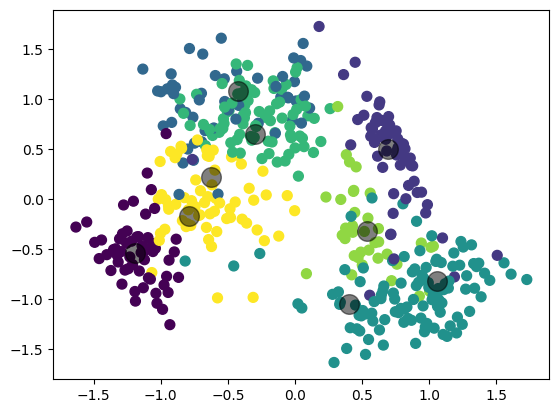

In [58]:
import matplotlib.pyplot as plt

# Plot the clusters in a two-dimensional space
dim1, dim2 = 0, 6 # can be any two dimensions
plt.scatter(X.iloc[:, dim1], X.iloc[:, dim2], c=X_clustered, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, dim1], centers[:, dim2], c='black', s=200, alpha=0.5)

plt.show()

#### Evaluating clustering performance
Evaluate the quality of the clusters using the silhoutte index

In [49]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
base_silhoutte = silhouette_score(X, X_clustered)

silhoutte_without_time_step = np.zeros(l)
for i in range(len(X_without_time_step)):
    silhoutte_without_time_step[i] = silhouette_score(X_without_time_step[i], X_clustered_without_time_step[i])
    
    print("Silhoutte score for kmeans using the dataset without time step %i: " % (i + 1), silhoutte_without_time_step[i])

print("Silhoutte score for kmeans using the whole dataset: ", base_silhoutte)

for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    X_clustered_K = kmeans.predict(X)
    base_silhoutte_K = silhouette_score(X, X_clustered_K)
    print("Silhoutte score for kmeans with %i clusters: " %(k), base_silhoutte_K)


Silhoutte score for kmeans using the dataset without time step 1:  0.29813392976351577
Silhoutte score for kmeans using the dataset without time step 2:  0.3039963424358252
Silhoutte score for kmeans using the dataset without time step 3:  0.31165917723978304
Silhoutte score for kmeans using the dataset without time step 4:  0.30831446643986377
Silhoutte score for kmeans using the dataset without time step 5:  0.28466261832707046
Silhoutte score for kmeans using the dataset without time step 6:  0.2688603904229043
Silhoutte score for kmeans using the dataset without time step 7:  0.2814715284938461
Silhoutte score for kmeans using the whole dataset:  0.3052002656405528
Silhoutte score for kmeans with 2 clusters:  0.41119467900095547
Silhoutte score for kmeans with 3 clusters:  0.38667901669748783
Silhoutte score for kmeans with 4 clusters:  0.3810762842794927
Silhoutte score for kmeans with 5 clusters:  0.386493449058845
Silhoutte score for kmeans with 6 clusters:  0.31073493173064404


## Comparison with existing research
Calculate the average proportion of non-overlap measure  
V1(K) = 1/(M*l) * sum_{g=1}^{M}(sum_{i=1}^{l}(1-n(C_g,i intersection C_g,0)/(n*C_g,0)))  

In [50]:
# Calculate the average proportion of non-overlap measure
# V1(K) = 1/(M*l) * sum_{g=1}^{M}(sum_{i=1}^{l}(1-n(C_g,i intersection C_g,0)/(n*C_g,0)))
# l = 7 is the number of dims (time steps)
# M = 474 is the number of genes
# C_g,i denote the cluster containing gene g in the clustering based on the data set with time Ti observations deleted.

average_proportion_non_overlap = 0
for g in range(M):
    # Get the original elements of a cluster C_g_0
    cluster_g_0 = (X_clustered == X_clustered[g])
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        cluster_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])

        # Calculate the number of elements in the intersection of the two clusters
        intersection_of_Cs = sum([a and b for a, b in zip(cluster_g_0, cluster_g_i)])

        average_proportion_non_overlap += 1/(M*l) * (1 - intersection_of_Cs/(sum(cluster_g_0)))
average_proportion_non_overlap

np.float64(0.2198740163236565)

Calculate the average distance between means measure  
V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))  

In [51]:
from scipy.spatial.distance import euclidean

# The average distance between means measure
# V2(K) = 1/Ml*sum_g=1..M (sum_i=1..l(d(mean(C_g,i),mean(C_g,0))))
average_distance_between_means = 0

for g in range(M):
    # Create a bool array with True for the elements in the cluster C_g_0
    C_g_0 = (X_clustered == X_clustered[g])
    # Filter the data frame with the bool array to get the genes in the cluster C_g_0
    C_g_0 = X.iloc[C_g_0]
    # Calculate the mean of every time step of the genes in the cluster C_g_0 
    mean_C_g_0 = np.zeros(l)
    for i in range(l):
        mean_C_g_0[i] = np.mean(C_g_0.iloc[:, i])

    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        # Create a bool array with True for the elements in the cluster C_g_i
        C_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])
        # Filter the data frame with the bool array to get the genes in the cluster C_g_i
        C_g_i = X.iloc[cluster_g_i]
        # Calculate the mean of every time step of the genes in the cluster C_g_i 
        mean_C_g_i = np.zeros(l)
        for j in range(l):
            mean_C_g_i[j] = np.mean(C_g_i.iloc[:, j])
        
        average_distance_between_means += 1/(M*l) * euclidean(mean_C_g_0, mean_C_g_i)
average_distance_between_means

2.372057346679048

Calculate the average distance measure  
V3(K) = 1/Ml*sum_g=1..M (sum_i=1..l(1/(n(C_g,i)n(C_g,0))*sum_{g' element of C_g,i, g element of C_g,0}d(x_g,x_g')))  

In [52]:
# The average distance measure
# V3(K) = 1/Ml*sum_g=1..M (sum_i=1..l(1/(n(C_g,i)n(C_g,0))*sum_{g' element of C_g,i, g element of C_g,0}d(x_g,x_g')))
average_distance_measure = 0
for g in range(M):
    # Calculate the number of elements in the cluster C_g_0
    C_g_0 = (X_clustered == X_clustered[g])
    n_C_g_0 = sum(cluster_g_0)
    for i in range(l):
        # cluster containing gene g in the clustering based on the data set with time Ti observations deleted
        # Calculate the number of elements in the cluster C_g_i
        C_g_i = (X_clustered_without_time_step[i] == X_clustered_without_time_step[i][g])
        n_C_g_i = sum(cluster_g_i)

        # Calculate the sum of distances d(x_g, x_g')
        distance_sum = 0
        for g_prime in range(M):
            if cluster_g_i[g_prime]:
                # Compute the distance between the expression profiles of gene g and g'
                distance_sum += euclidean(X.iloc[g, :], X.iloc[g_prime, :])  # Use Euclidean distance, but can use another metric

        # Add to the average distance measure formula
        average_distance_measure += (1 / (M * l)) * (1 / (n_C_g_0 * n_C_g_i)) * distance_sum
average_distance_measure

np.float64(0.04429019394535473)

The result is about 12 times smaller than the one in the paper, so there might be a mistake, or it might be the result of a different datasets

#### Average temporal profiles
Visualize the average temporal profiles of the seven groups obtained using the K-Means algorithm  
In the paper the average of the log-expression ratio are plotted, but we have negative values, so to log-transform the data we would first have to make all values positive, which I don't think is a good idea, which is why here in our visualization the values don't start around 0 at time 0  

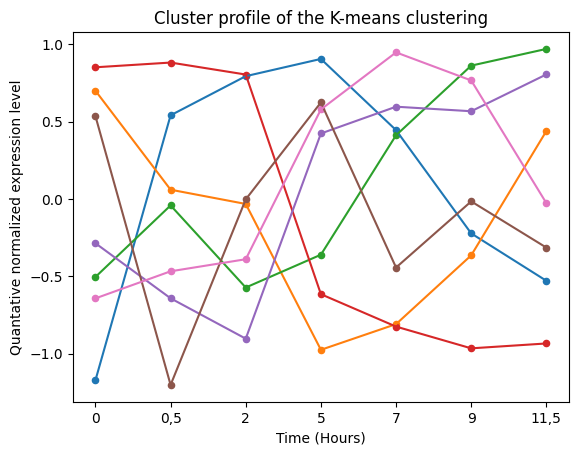

In [53]:
# Calculate the cluster profile of the K-means clustering
cluster_profile = np.zeros((l, clusters))
for i in range(clusters):
    # Create a bool array with True for the elements in the cluster i
    cluster_elements = (X_clustered == i)
    # Filter the data frame with the bool array to get the genes in the cluster i
    cluster_elements = X.iloc[cluster_elements]
    # Calculate the mean of every time step of the genes in the cluster i
    for j in range(l):
        cluster_profile[i][j] = np.mean(cluster_elements.iloc[:, j])

# plot the cluster profile
# Time points
time_points = ['0', '0,5', '2', '5', '7', '9', '11,5']
for i in range(clusters):
    # make the points bigger
    plt.scatter(range(l), cluster_profile[i], s=20)
    plt.plot(cluster_profile[i])
# Add time points to the x-axis
plt.xlabel('Time (Hours)')
plt.xticks(range(l), time_points)
plt.ylabel('Quantative normalized expression level')
plt.title('Cluster profile of the K-means clustering')

plt.show()

We can't compare the cluster profiles with the model profiles as we don't know how the model profiles look.  
Therefore weare unable to compute the total distance from the model profile.  

#### Normalizing the data to start at 0 at time step 0 so that we can see the relative increase/decrease in the expression levels of the clusters from the start of the sporulation

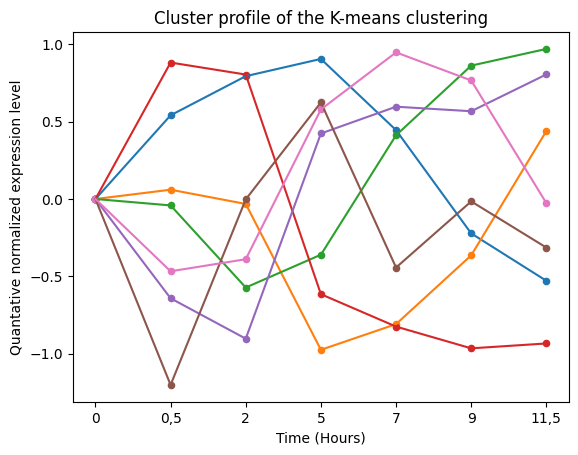

In [60]:
# Set the t0 to 0 and substract the value in all the other time points
X_normalized = X.copy()
for i in time_points:
    X_normalized['t' + i] -= X_normalized['t0']

# Calculate the cluster profile of the K-means clustering
cluster_profile = np.zeros((l, clusters))
for i in range(clusters):
    # Create a bool array with True for the elements in the cluster i
    cluster_elements = (X_clustered == i)
    # Filter the data frame with the bool array to get the genes in the cluster i
    cluster_elements = X_normalized.iloc[cluster_elements]
    # Calculate the mean of every time step of the genes in the cluster i
    for j in range(l):
        cluster_profile[i][j] = np.mean(cluster_elements.iloc[:, j])

# plot the cluster profile
# Time points
for i in range(clusters):
    # make the points bigger
    plt.scatter(range(l), cluster_profile[i], s=20)
    plt.plot(cluster_profile[i])
# Add time points to the x-axis
plt.xlabel('Time (Hours)')
plt.xticks(range(l), time_points)
plt.ylabel('Quantative normalized expression level')
plt.title('Cluster profile of the K-means clustering')

plt.show()